## Gaining insights and future predictions from **Stock time series data**

### Time Series Analysis of AAPL
This notebook performs time series analysis on one of the popular stocks: **Apple (AAPL)** `using historical price data from Yahoo Finance.

We'll cover:
* Load Data
* Preprocessing(null values)
* Initial plot
* Decompose Time Series → visualize trend/seasonality/residual
* Check stationarity if applying ARIMA/SARIMA/GARCH otherwise if forecasting we need both trend and seasonality
* Applying triple exponential smoothing model on the data for the forecasting

### Importing Libraries and Data

In [2]:
import yfinance as yf
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


aapl=yf.download('AAPL', start='2024-01-01', end='2025-04-30')
aapl.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.290421,187.070068,182.553143,185.789438,82488700
2024-01-03,182.910522,184.528677,182.096477,182.880742,58414500
2024-01-04,180.587540,181.758954,179.565029,180.825785,71983600
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300
2024-01-08,184.211014,184.250731,180.180532,180.766239,59144500


### Plotting an initial plot for Close Price

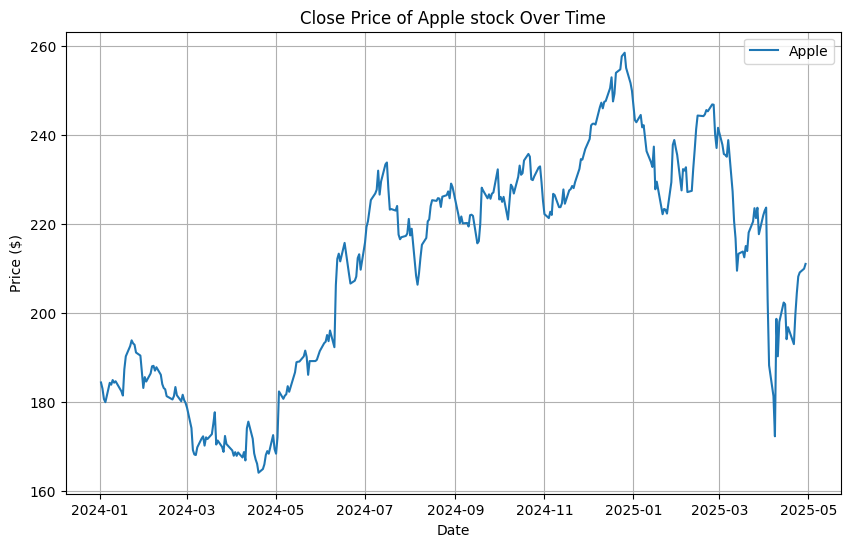

In [3]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(aapl['Close'], label='Apple')
plt.title('Close Price of Apple stock Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()

plt.show()

### Time Series Decomposition on the Stock data


Decomposition with period = 5


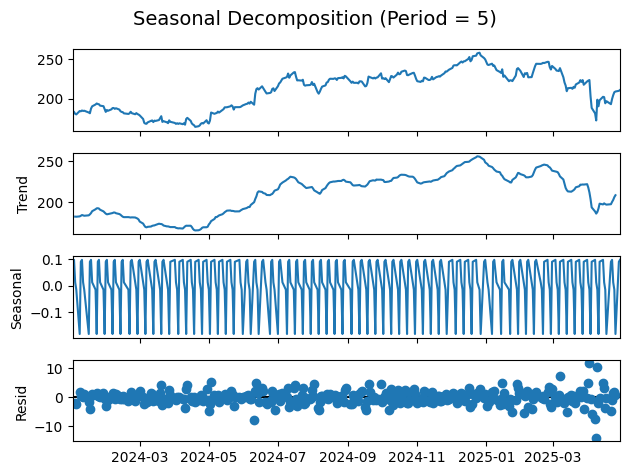


Decomposition with period = 21


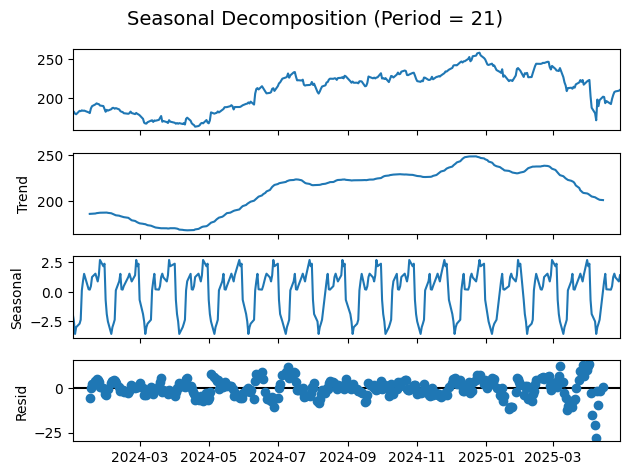


Decomposition with period = 63


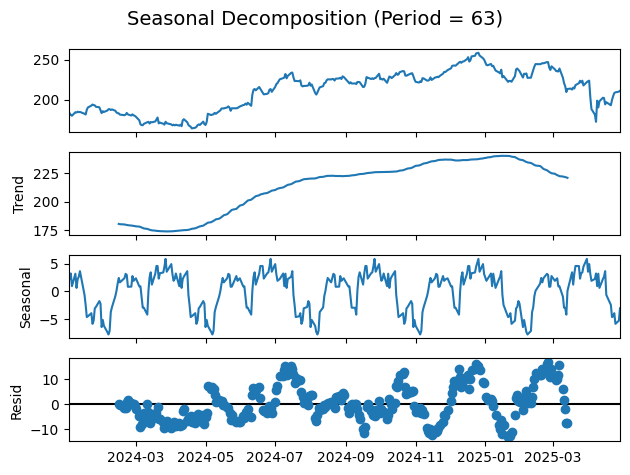

In [4]:
from statsmodels.tsa.seasonal import STL
periods = [5, 21, 63]
for p in periods:
    print(f"\nDecomposition with period = {p}")
    result = seasonal_decompose(aapl['Close'], model='additive', period=p)
    result.plot()
    plt.suptitle(f'Seasonal Decomposition (Period = {p})', fontsize=14)
    plt.tight_layout()
    plt.show()

In [5]:
print("On visual inspection we can see that the period=5 is the most suitable as the residual has no pattern and is random and this period is also good for short term forecasting.")

On visual inspection we can see that the period=5 is the most suitable as the residual has no pattern and is random and this period is also good for short term forecasting.


### Applying Holt's Winters Method on the data for forecasting

Period = 5 | MAPE = 0.1101
Validation MAPE: 0.1101
Test MSE: 892.4819
Test RMSE: 29.8744
Test MAPE: 0.1101


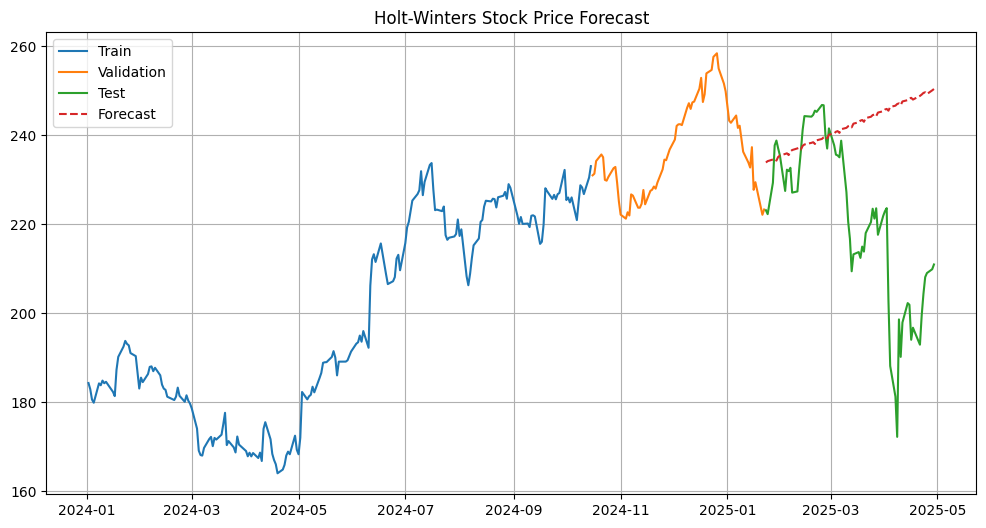

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

train_size = int(len(aapl['Close']) * 0.6)
val_size = int(len(aapl['Close']) * 0.20)
train = aapl['Close'].iloc[:train_size]
val = aapl['Close'].iloc[train_size:train_size + val_size]
test = aapl['Close'].iloc[train_size + val_size:]
best_mape = float('inf')
best_model = None


p = 5

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=p)
fit = model.fit(optimized=True)  # This line auto-tunes α, β, γ
pred = fit.forecast(len(test))

mape = mean_absolute_percentage_error(test, pred)

print(f"Period = {p} | MAPE = {mape:.4f}")

if mape < best_mape:
    best_mape = mape
    best_model = fit
    best_period = p

print(f"Validation MAPE: {best_mape:.4f}")

# Forecast on test data
forecast = pd.Series(best_model.forecast(len(test)))
# Evaluation on test data
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(val, label='Validation')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("Holt-Winters Stock Price Forecast")
plt.grid()
plt.show()